In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import io 

from pathlib import Path
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit, minimize

from aiida import load_profile
from aiida.orm import Dict, load_node
from aiida.plugins import DataFactory

from aiida_vasp_ext_mlauer.util.functions import Murnaghan

load_profile('lauerm-test')

Profile<uuid='34741e4bf9c34bd7b9ae17bef7c5da2e' name='lauerm-test'>

In [12]:
def locate_minimum_interpolate(total_energies):
    total_energies_array = total_energies.get_array('eos')

    volumes = total_energies_array[:,0]
    energies = total_energies_array[:,1]

    ## get minimum energy guess
    min_energy_guess_idx = energies.argmin()

    new_energies = CubicSpline(volumes, energies)
    min_energy_point = minimize(new_energies, volumes[min_energy_guess_idx], tol=1e-3)  # I should make these numbers optional under wc_metadata.plot_options

    # Store Result
    dict_data = {'volume': min_energy_point.x[0], 'energy': min_energy_point.fun}

    parameters = {'type': '1D cubic Interpolation'}

    return {
        "min_energy": Dict(dict = dict_data), 
        "parameters": Dict(dict = parameters) 
    }

In [72]:
def locate_minimum_murnaghan(total_energies):
    total_energies_array = total_energies.get_array('eos')

    volumes = total_energies_array[:,0]
    energies = total_energies_array[:,1]

    # Document Type of Analysis
    parameters = {'type': 'Murnaghan EoS Fit'}

    ## get minimum energy guess
    min_energy_guess_idx = energies.argmin()

    ## Fit Murnaghan Equation of State
    params, covar = curve_fit(Murnaghan, volumes, energies, p0=[energies[min_energy_guess_idx], volumes[min_energy_guess_idx], 10, 2.5])
    print(params)
    parameters |= {'E0': params[0], 
                   'V0': params[1], 
                   'K0': params[2], 
                   'K1': params[3],
                   #'covariance': covar.tolist()
                   }

    min_energy_point = Murnaghan(params[1], *params)

    # Store Result
    dict_data = {'volume': params[0], 'energy': min_energy_point}

    return {
        "min_energy": Dict(dict = dict_data), 
        "parameters": Dict(dict = parameters) 
    }

locate_minimum_murnaghan(total_energies)

[-4.87737532 14.59544406 31.52344671  3.76631628]


{'min_energy': <Dict: uuid: 19d0f467-7e41-42f6-b5b0-b950d87d185f (unstored)>,
 'parameters': <Dict: uuid: 4cf613fe-9675-4cac-aff8-51fbbeff2533 (unstored)>}

In [66]:
def create_plot(total_energies, parameters):
    total_energies_array = total_energies.get_array('eos')
    parameters = parameters.get_dict()

    volumes = total_energies_array[:,0]
    energies = total_energies_array[:,1]
    type = parameters['type'] 

    x_fit = np.linspace(volumes.min() - 1, volumes.max() + 1, 500)

    fig, ax = plt.subplots()
    ax.scatter(volumes, energies)

    match type:
        case "Murnaghan EoS Fit":
            params = [parameters.get(para) for para in ['E0', 'V0', 'K0', 'K1']]
            v0 = parameters.get('V0')
        
            ax.set_title('Murnaghan EoS Plot') # I should make these numbers optional under wc_metadata.plot_options
            y_fit = Murnaghan(x_fit, *params)

            ax.plot(x_fit, y_fit, label='Murnaghan Fit', color='orange')
            

        case "1D cubic Interpolation":
            min_energy_guess_idx = energies.argmin()
            y_fit = CubicSpline(volumes, energies)
            
            v0 = minimize(y_fit, min_energy_guess_idx, tol=1e-3).x[0]

            ax.set_title("Interpolated EoS Plot")
            ax.plot(x_fit, y_fit(x_fit))
    
    ax.axvline(x=v0, color='grey', linestyle='--', label=f'$V_0 = {v0:.3f} A^3$')

    ax.set_xlabel(r'Volume / $10^\mathrm{-30} m^\mathrm{3}$')
    ax.set_ylabel(r'Energy / eV')
    ax.legend()

    buffer = io.BytesIO()
    fig.savefig(buffer, format='png')
    plt.close(fig)

    buffer.seek(0)

    plot_file = DataFactory('core.singlefile')(file=buffer, filename='eos_plot.png')

    return plot_file

In [76]:
total_energies = load_node(743)
parameters = load_node(746)

d = locate_minimum_murnaghan(total_energies)
a = create_plot(total_energies, d['parameters'])
c = create_plot(total_energies, parameters=Dict(dict={'type': '1D cubic Interpolation'}))

[-4.87737532 14.59544406 31.52344671  3.76631628]


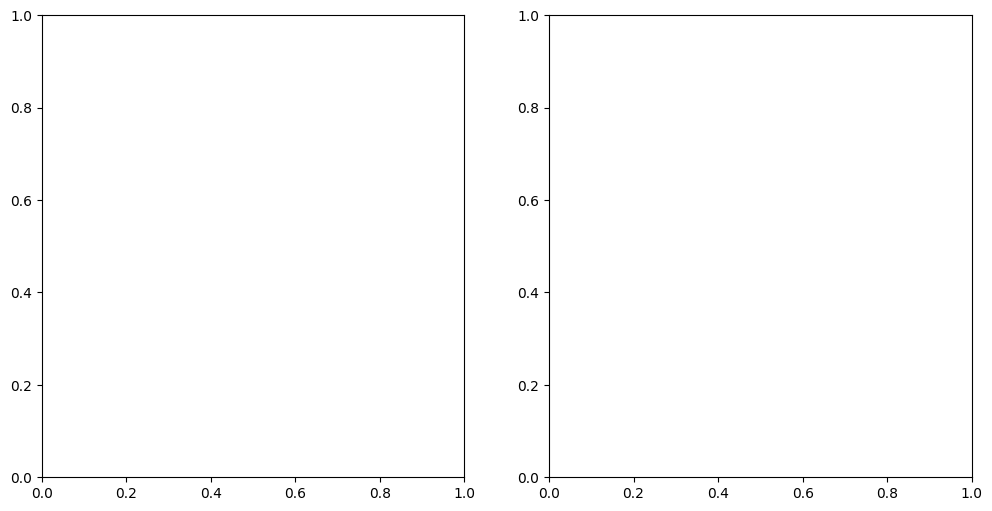

In [83]:
from PIL import Image
fig, axes = plt.subplots(1,2, figsize=(12,6))

b = a.get_content(mode='rb')
Image_data = Image.open(io.BytesIO(b))

Image_data.show()

b = c.get_content(mode='rb')
Image_data = Image.open(io.BytesIO(b))

Image_data.show()